<a href="https://colab.research.google.com/github/Numann-Malik/Project-2/blob/main/CarInsurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Project
- Numann Malik
- Wednesday January 18th

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Inspecting Data

In [4]:
filename = '/content/drive/MyDrive/Coding Dojo/07 Week 7: Classification Models/Car_Insurance_Claim.csv'
df = pd.read_csv(filename)

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


# Data Cleaning

In [6]:
df = df.drop(['ID'],axis=1)
df.info() # Dropped unnecessary 'ID' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null  

In [7]:
df.duplicated().sum() # 12 duplicate rows

12

In [8]:
df = df.drop_duplicates()
df.duplicated().sum() # Duplicate rows have been dropped

0

In [9]:
df.shape

(9988, 18)

In [10]:
df.isna().sum()
# Out of 9,988 rows there are 970 values missing for 'Credit Score', and 954 values missing for blood pressure 'Annual Mileage' (both roughly around 10%)
# We will leave them now for EDA purposes, later we will use SimpleImputer when preprocessing for modeling

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           970
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         954
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [19]:
df.describe()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,9988.000000,9988.000000,9988.000000,9988.00000,9034.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,0.515813,0.697537,0.498698,0.689327,19873.85873,11694.598185,1.484581,0.239487,1.057369,0.312775
std,0.137688,0.459348,0.500023,0.462792,18923.83540,2818.004386,2.242766,0.555262,1.653047,0.463647
min,0.053358,0.000000,0.000000,0.000000,10238.00000,2000.000000,0.000000,0.000000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10238.00000,10000.000000,0.000000,0.000000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,10238.00000,12000.000000,0.000000,0.000000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,32765.00000,14000.000000,2.000000,0.000000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,92101.00000,22000.000000,22.000000,6.000000,15.000000,1.000000


Using the approved dataset you proposed for project 2 part 1 last week, you will clean and explore the data set.

To meet the requirements for this week you must have:
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
- Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

# Univariate Exploratory Visualizations

In [15]:
## functionize a barplot and call it plot_bar

def plot_bar(data,x, y, figsize=(20,5)):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots(figsize=figsize)

    ## Plot barplot
    
    ## counts, counts up the categories, sort the values, then puts them in a 
    ## data frame.
    
    counts = df[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 45)
    ax.set_title(f'Categorical Frequencies of {y}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'Categories for {y}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax

0.0    6864
1.0    3124
Name: OUTCOME, dtype: int64


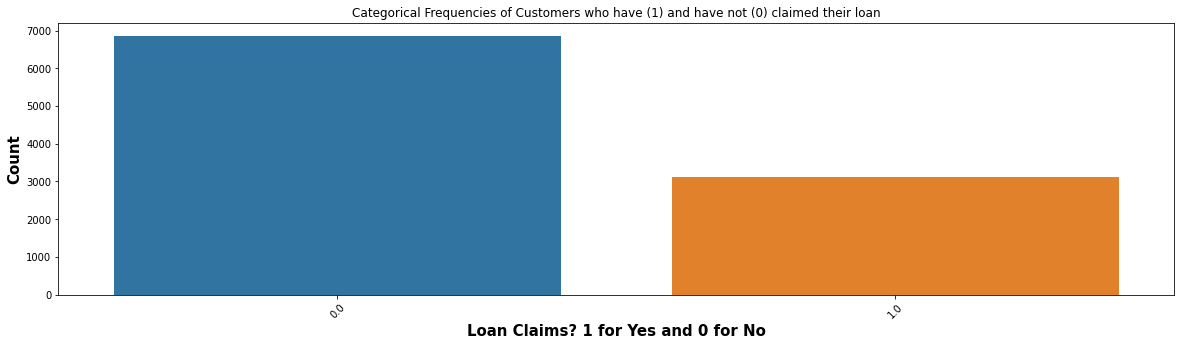

In [20]:
fig, ax = plot_bar(df, 'OUTCOME', 'OUTCOME');
plt.xlabel('Loan Claims? 1 for Yes and 0 for No')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Customers who have (1) and have not (0) claimed their loan');
print(df['OUTCOME'].value_counts())

26-39    3062
40-64    2931
16-25    2005
65+      1990
Name: AGE, dtype: int64


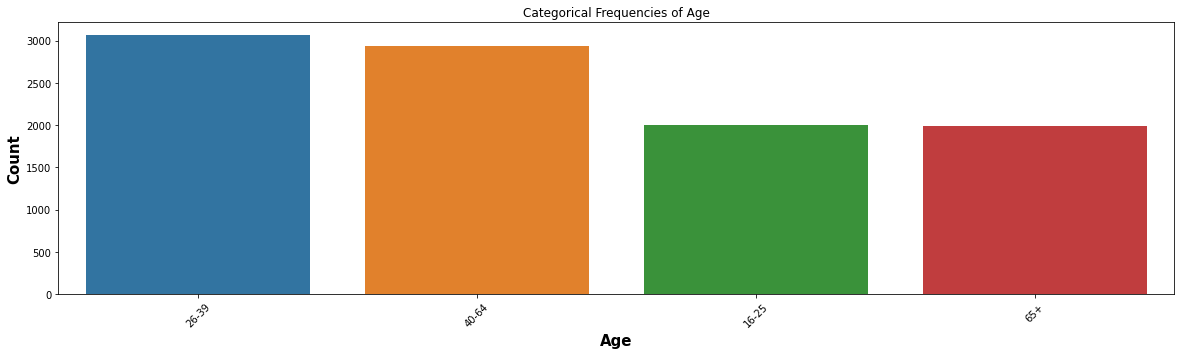

In [19]:
fig, ax = plot_bar(df, 'AGE', 'AGE');
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Age');
print(df['AGE'].value_counts())

female    5003
male      4985
Name: GENDER, dtype: int64


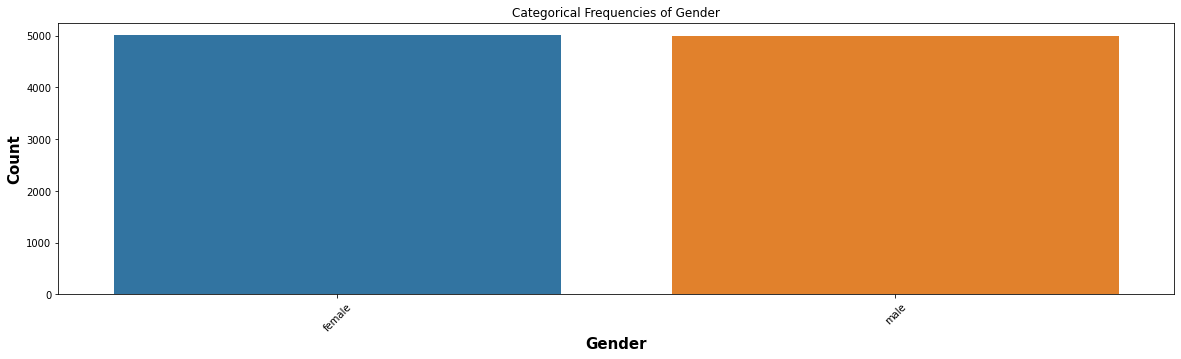

In [18]:
fig, ax = plot_bar(df, 'GENDER', 'GENDER');
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Gender');
print(df['GENDER'].value_counts())

majority    9000
minority     988
Name: RACE, dtype: int64


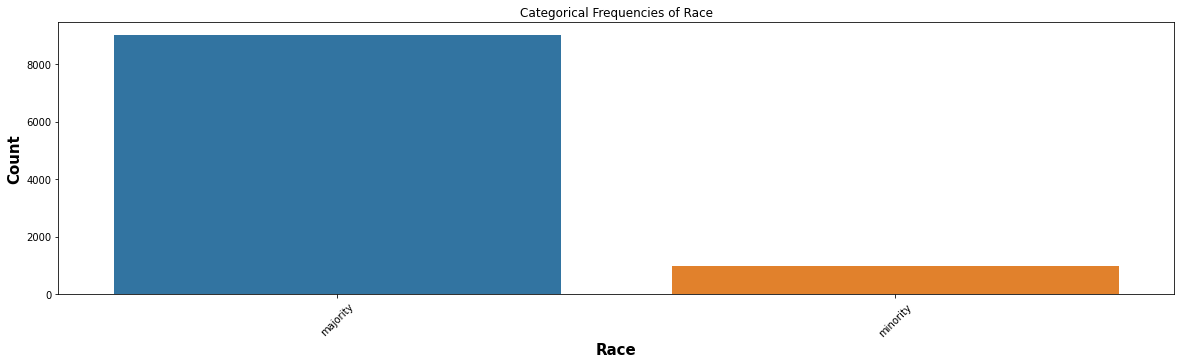

In [16]:
fig, ax = plot_bar(df, 'RACE', 'RACE');
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Race');
print(df['RACE'].value_counts())

0-9y      3519
10-19y    3298
20-29y    2119
30y+      1052
Name: DRIVING_EXPERIENCE, dtype: int64


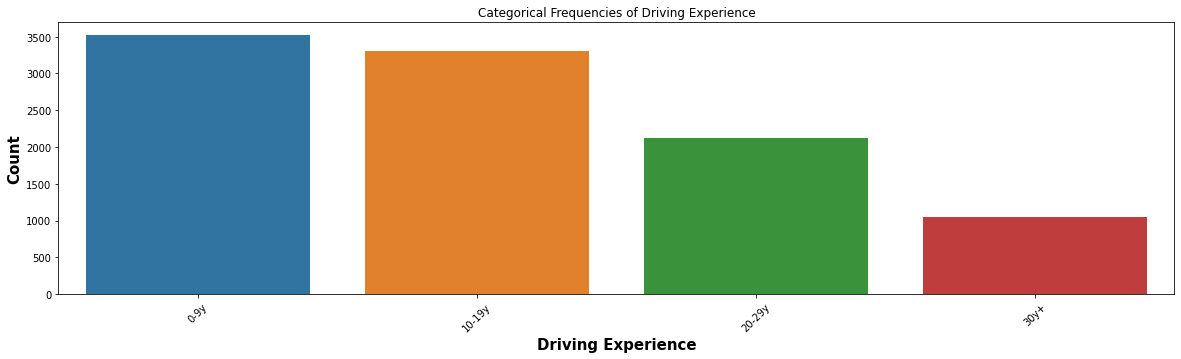

In [21]:
fig, ax = plot_bar(df, 'DRIVING_EXPERIENCE', 'DRIVING_EXPERIENCE');
plt.xlabel('Driving Experience')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Driving Experience');
print(df['DRIVING_EXPERIENCE'].value_counts())

high school    4151
university     3927
none           1910
Name: EDUCATION, dtype: int64


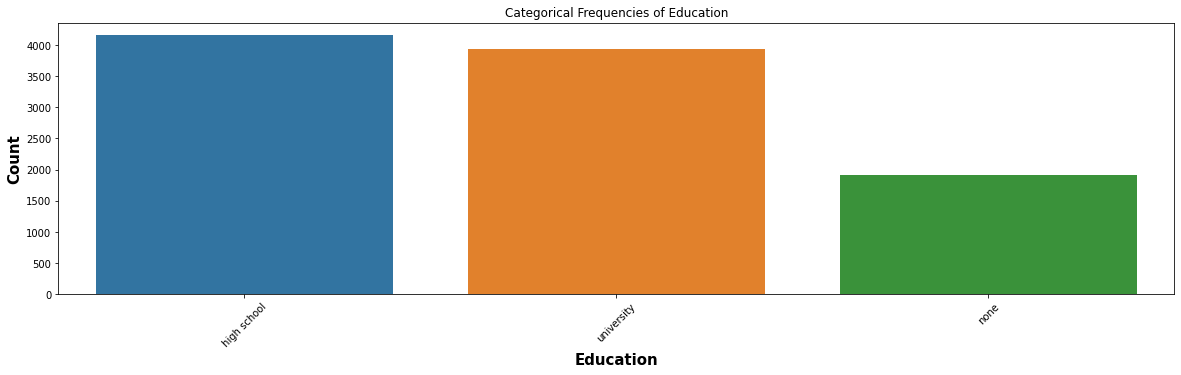

In [22]:
fig, ax = plot_bar(df, 'EDUCATION', 'EDUCATION');
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Education');
print(df['EDUCATION'].value_counts())

upper class      4335
middle class     2138
poverty          1804
working class    1711
Name: INCOME, dtype: int64


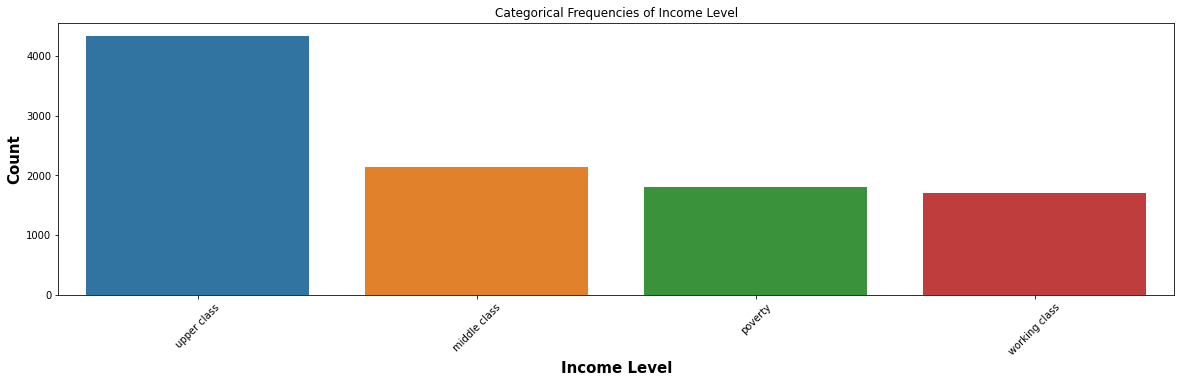

In [17]:
fig, ax = plot_bar(df, 'INCOME', 'INCOME');
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Income Level');
print(df['INCOME'].value_counts())

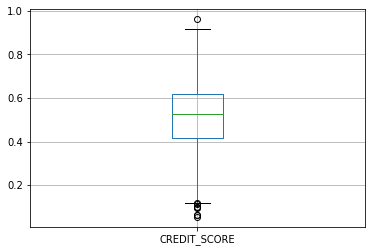

In [25]:
boxplot = df.boxplot(column=['CREDIT_SCORE'])

In [26]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [27]:
outliers = find_outliers_IQR(df['CREDIT_SCORE'])

print(f'number of outliers:' + str(len(outliers)))

print(f'max outlier value:' + str(outliers.max()))

print(f'min outlier value:' + str(outliers.min()))

outliers

number of outliers:9
max outlier value:0.9608188278116948
min outlier value:0.0533575454627435


2152    0.053358
4955    0.064810
6031    0.060867
6752    0.099655
7784    0.112631
8039    0.095387
8057    0.960819
8194    0.097211
9648    0.115402
Name: CREDIT_SCORE, dtype: float64

1.0    6967
0.0    3021
Name: VEHICLE_OWNERSHIP, dtype: int64


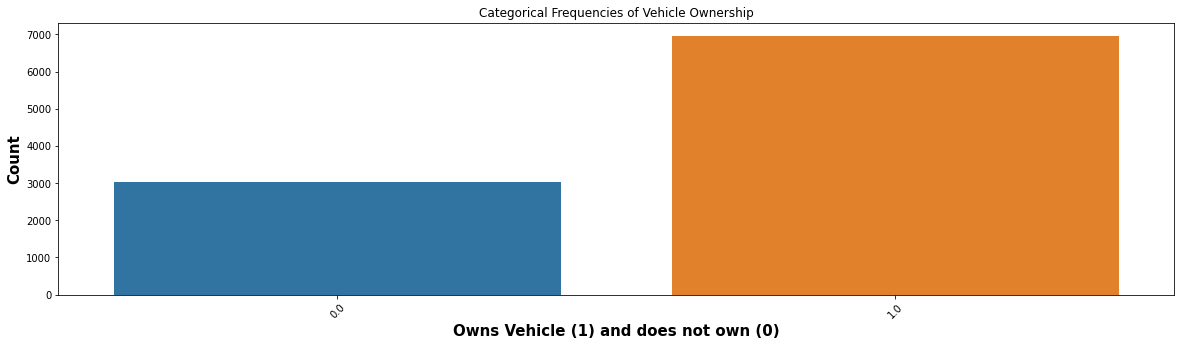

In [48]:
fig, ax = plot_bar(df, 'VEHICLE_OWNERSHIP', 'VEHICLE_OWNERSHIP');
plt.xlabel('Owns Vehicle (1) and does not own (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Ownership');
print(df['VEHICLE_OWNERSHIP'].value_counts())

before 2015    6955
after 2015     3033
Name: VEHICLE_YEAR, dtype: int64


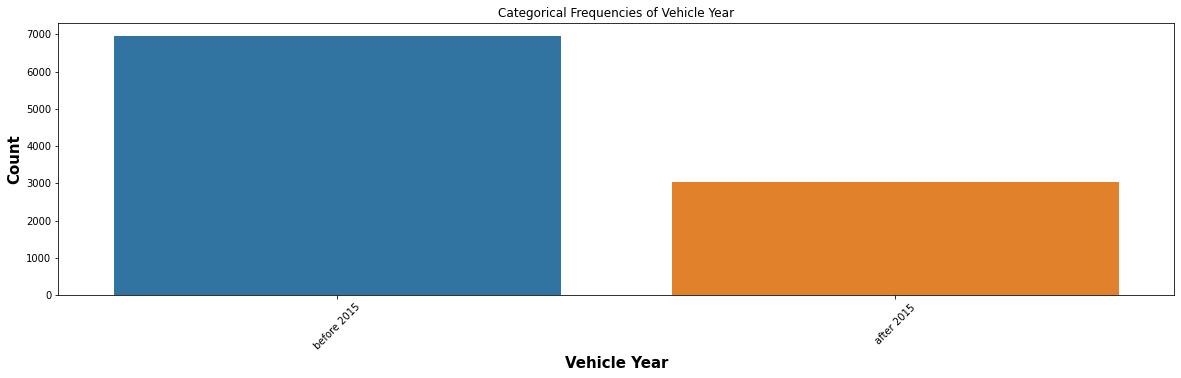

In [31]:
fig, ax = plot_bar(df, 'VEHICLE_YEAR', 'VEHICLE_YEAR');
plt.xlabel('Vehicle Year')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Year');
print(df['VEHICLE_YEAR'].value_counts())

0.0    5007
1.0    4981
Name: MARRIED, dtype: int64


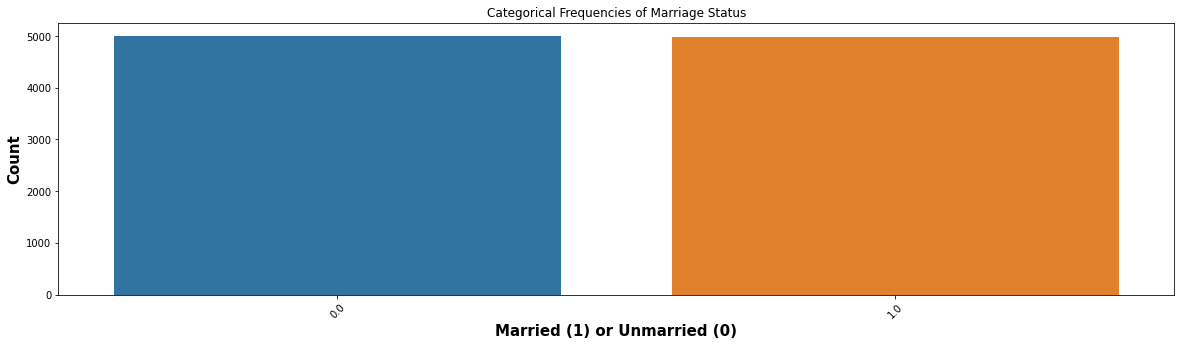

In [35]:
fig, ax = plot_bar(df, 'MARRIED', 'MARRIED');
plt.xlabel('Married (1) or Unmarried (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Marriage Status');
print(df['MARRIED'].value_counts())

1.0    6885
0.0    3103
Name: CHILDREN, dtype: int64


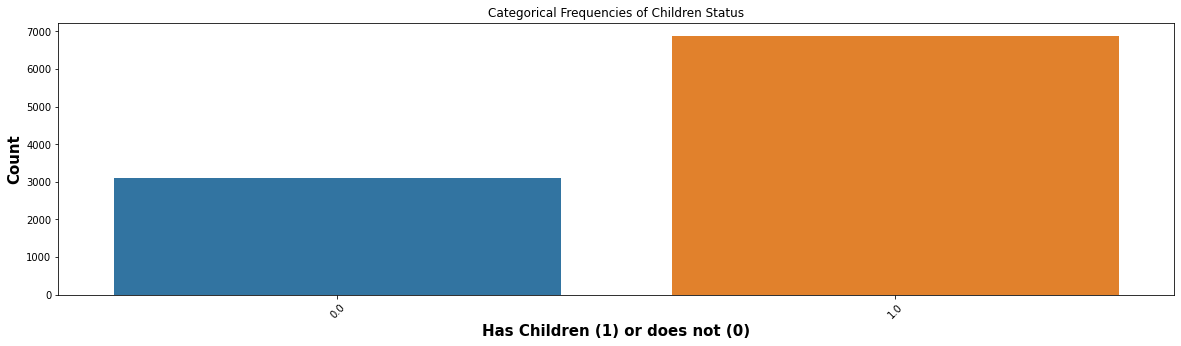

In [49]:
fig, ax = plot_bar(df, 'CHILDREN', 'CHILDREN');
plt.xlabel('Has Children (1) or does not (0)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Children Status');
print(df['CHILDREN'].value_counts())

10238    6929
32765    2455
92101     484
21217     120
Name: POSTAL_CODE, dtype: int64


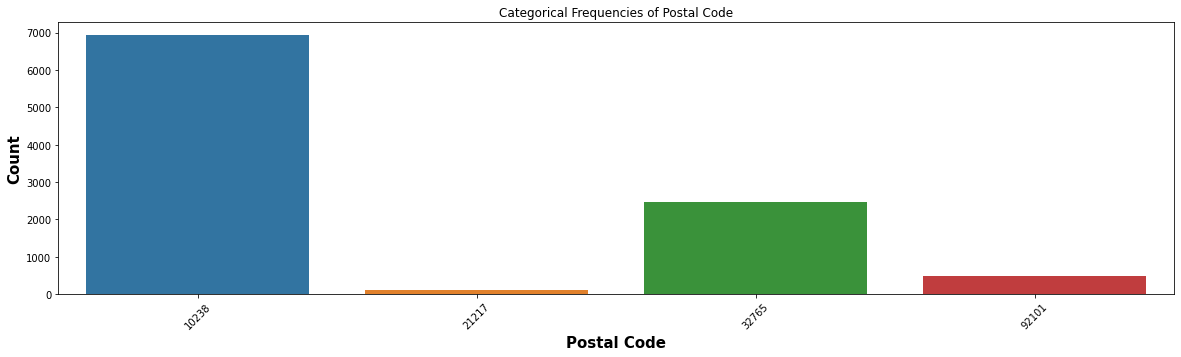

In [39]:
fig, ax = plot_bar(df, 'POSTAL_CODE', 'POSTAL_CODE');
plt.xlabel('Postal Code')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Postal Code');
print(df['POSTAL_CODE'].value_counts())

11000.0    1253
12000.0    1218
13000.0    1136
10000.0    1071
14000.0     891
9000.0      855
15000.0     630
8000.0      557
16000.0     418
7000.0      322
17000.0     245
6000.0      165
18000.0     103
5000.0       65
19000.0      48
4000.0       27
20000.0      13
3000.0       10
21000.0       3
2000.0        2
22000.0       2
Name: ANNUAL_MILEAGE, dtype: int64


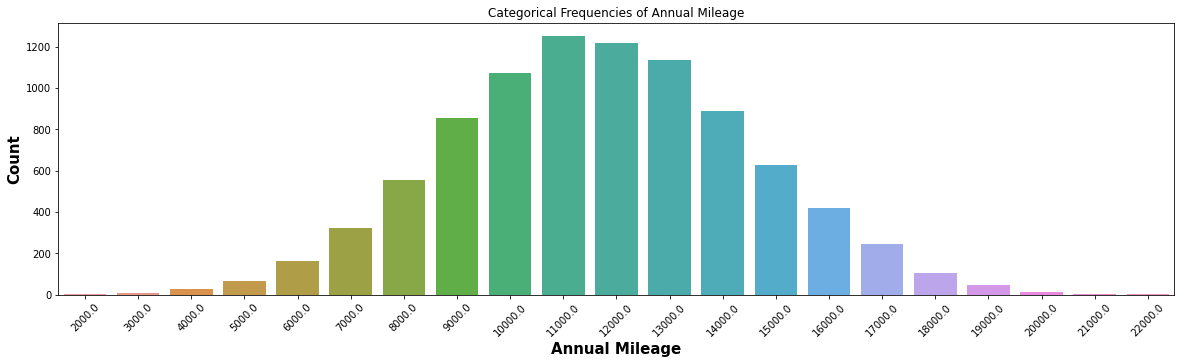

In [41]:
fig, ax = plot_bar(df, 'ANNUAL_MILEAGE', 'ANNUAL_MILEAGE');
plt.xlabel('Annual Mileage')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Annual Mileage');
print(df['ANNUAL_MILEAGE'].value_counts())

sedan         9511
sports car     477
Name: VEHICLE_TYPE, dtype: int64


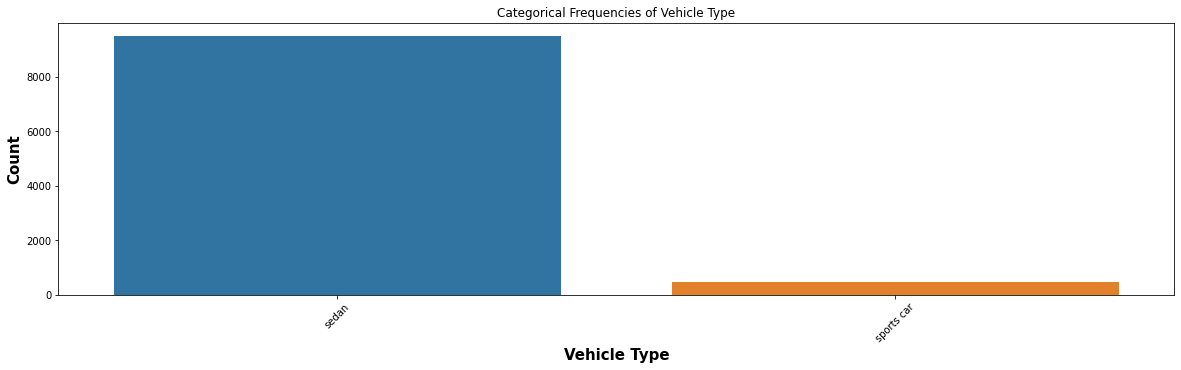

In [32]:
fig, ax = plot_bar(df, 'VEHICLE_TYPE', 'VEHICLE_TYPE');
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Vehicle Type');
print(df['VEHICLE_TYPE'].value_counts())

0     5017
1     1543
2     1161
3      830
4      530
5      319
6      188
7      140
8       75
10      50
9       49
11      30
12      20
13      12
15       8
14       5
16       4
17       3
19       2
18       1
22       1
Name: SPEEDING_VIOLATIONS, dtype: int64


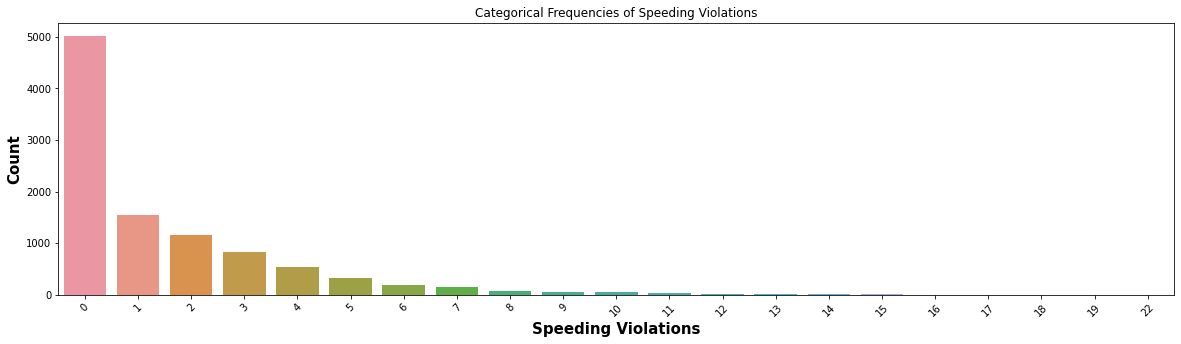

In [43]:
fig, ax = plot_bar(df, 'SPEEDING_VIOLATIONS', 'SPEEDING_VIOLATIONS');
plt.xlabel('Speeding Violations')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Speeding Violations');
print(df['SPEEDING_VIOLATIONS'].value_counts())

0    8106
1    1470
2     331
3      68
4      10
5       2
6       1
Name: DUIS, dtype: int64


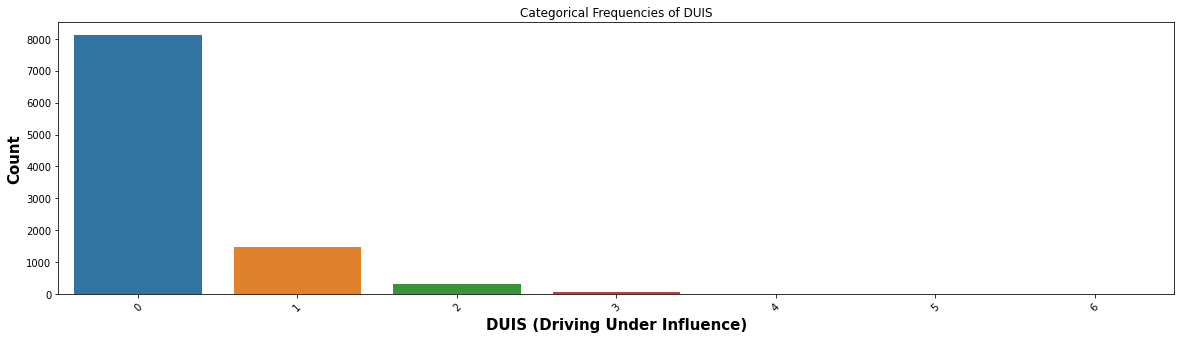

In [45]:
fig, ax = plot_bar(df, 'DUIS', 'DUIS');
plt.xlabel('DUIS (Driving Under Influence)')
plt.ylabel('Count')
plt.title('Categorical Frequencies of DUIS');
print(df['DUIS'].value_counts())

0     5573
1     1783
2     1103
3      646
4      366
5      232
6      144
7       61
8       41
9       19
10       9
11       7
12       2
14       1
15       1
Name: PAST_ACCIDENTS, dtype: int64


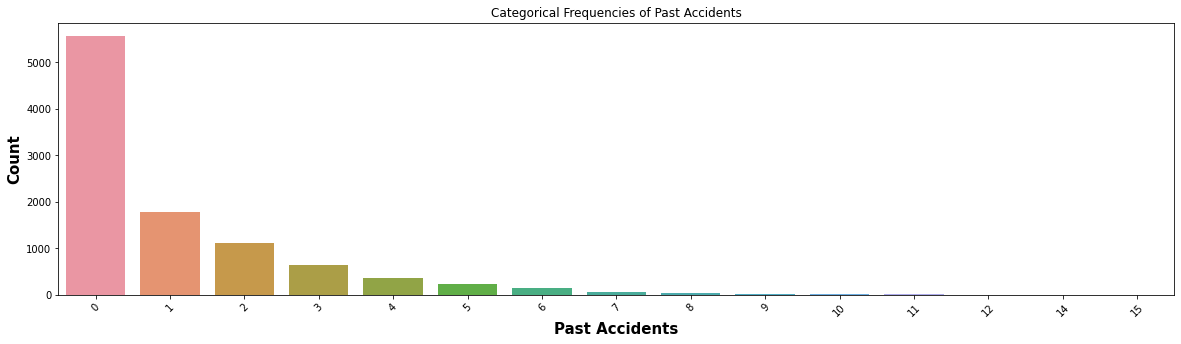

In [47]:
fig, ax = plot_bar(df, 'PAST_ACCIDENTS', 'PAST_ACCIDENTS');
plt.xlabel('Past Accidents')
plt.ylabel('Count')
plt.title('Categorical Frequencies of Past Accidents');
print(df['PAST_ACCIDENTS'].value_counts())

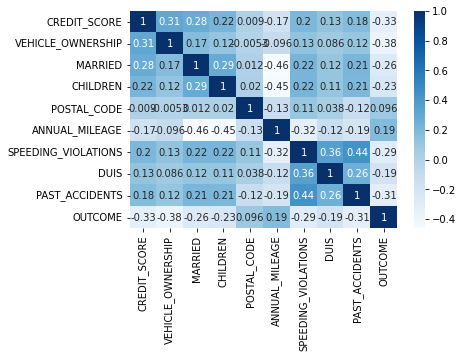

In [23]:
sns.heatmap(df.corr(),annot=True,cmap='Blues'); # Very little correlation between any of the features.